In [1]:
from NeuralNetwork.dense import Dense
from NeuralNetwork.losses import mse,mse_derive
from NeuralNetwork.activations import Sigmoid,Softmax
from NeuralNetwork.network import predict
import numpy as np
import pandas as pd
from tqdm import tqdm
import numpy as np
import pandas as pd
import struct
import matplotlib.pyplot as plt

In [20]:
EPOCH = 30
ALPHA = 0.08

In [3]:
def encode(z):
    if z>=0.5:
        return 1
    return 0

In [22]:
def load_mnist_images_to_df(filename):
    with open(filename, 'rb') as f:
        _ = struct.unpack('>I', f.read(4))[0]
        num_images = struct.unpack('>I', f.read(4))[0]
        num_rows = struct.unpack('>I', f.read(4))[0]
        num_cols = struct.unpack('>I', f.read(4))[0]
        image_data = f.read(num_images * num_rows * num_cols)
        images = np.frombuffer(image_data, dtype=np.uint8)
        images = images.reshape(num_images, num_rows * num_cols)
        df = pd.DataFrame(images)
    return df

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        magic = struct.unpack('>I', f.read(4))[0]
        num_labels = struct.unpack('>I', f.read(4))[0]
        label_data = f.read(num_labels)
        labels = np.frombuffer(label_data, dtype=np.uint8)        
    return labels


In [23]:
def train(NN, loss, loss_derive, X, Y, X_val,Y_val, epoch=EPOCH, alpha=ALPHA, verbose = True):
    error_TS = []
    acc_TS = []
    val_acc_TS = []
    val_error_TS = []
    for e in range(epoch):
        errors = 0
        acc = 0
        val_acc = 0
        val_error = 0
        for x, y in zip(X, Y):
            out = predict(NN, x)
            if y==encode(out):
                acc+=1
            errors += loss(y, out)
            gradient = loss_derive(y, out)
            for layer in reversed(NN):
                gradient = layer.backward(gradient, alpha)

        for x, y in zip(X_val, Y_val):
            output = predict(NN, x)
            if y==encode(output):
                val_acc+=1
            val_error += loss(y, output)

        errors /= len(X)
        acc /=len(X)
        val_error /= len(X_val)
        val_acc /=len(X_val)
        if verbose:
            print(f"{e + 1}/{epoch}, error={round(errors,4)}, accuracy={round(acc,4)}, val_error={round(val_error,4)}, val_accuracy={round(val_acc,4)}")
        error_TS.append(errors)
        acc_TS.append(acc)
        val_error_TS.append(val_error)
        val_acc_TS.append(val_acc)
    return [error_TS,acc_TS,val_error_TS,val_acc_TS]

In [24]:
class TreeNN():
    def __init__(self,depth=1,max_depth=3,parent_node = None):
        self.parent_node = parent_node
        self.NN = [
            Dense(784,1),
            Sigmoid()
        ]
        self.depth = depth
        self.max_depth = max_depth
        self.children = []
    
    def get_augemented(self,X,Y):
        Xa_train = []
        Xb_train = []
        for x, y in zip(X, Y):
            output = encode(predict(self.NN, x))
            if y!=output:
                if output==0 and y==1:
                    Xa_train.append(1)
                    Xb_train.append(0)
                if output==1 and y==0:
                    Xa_train.append(0)
                    Xb_train.append(1)

            else:
                if output==0 and y==0:
                    Xa_train.append(0)
                    Xb_train.append(1)

                if output==1 and y==1:
                    Xa_train.append(1)
                    Xb_train.append(0)
        return Xa_train,Xb_train
    
    def plot(self,metrics):
        metrics_names = ['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy']
        for i in range(len(metrics_names)):
            plt.plot(metrics[i])
            plt.xlabel("Epochs")
            plt.ylabel(metrics_names[i])
            plt.savefig("./graph/MNIST_{}_{}.png".format(metrics_names[i],self.depth))
            plt.clf()


    
    def train_tree(self,X,Y,X_val,Y_val):
        print("Layers :",self.depth)
        X_train = np.reshape(X,X.shape +(1,))
        Y_train = np.reshape(Y,Y.shape +(1,))
        X_val_in =np.reshape(X_val,X_val.shape +(1,))
        Y_val_in =np.reshape(Y_val,Y_val.shape +(1,))
        metrics = train(self.NN,mse,mse_derive,X_train,Y_train,X_val_in,Y_val_in)
        self.plot(metrics)
        if self.max_depth>self.depth+1:
            ## Adding Layers
            Na = TreeNN(depth=self.depth+1,max_depth=self.max_depth,parent_node=self)
            Nb = TreeNN(depth=self.depth+1,max_depth=self.max_depth,parent_node=self)
            self.children.append(Na)
            self.children.append(Nb)
            #Retrain with extra feature
            Xa_train,Xb_train = self.get_augemented(X_train,Y_train)
            X_retrain = np.column_stack((X, Xa_train))
            X_retrain = np.column_stack((X_retrain, Xb_train))
            X_retrain = np.reshape(X_retrain,X_retrain.shape+(1,))
            Xa,Xb = self.get_augemented(X_val_in,Y_val_in)
            X_reval = np.column_stack((X_val, Xa))
            X_reval = np.column_stack((X_reval, Xb))
            X_reval = np.reshape(X_reval,X_reval.shape+(1,))
            self.NN = [Dense(786,1),Sigmoid()]
            metrics = train(self.NN,mse,mse_derive,X_retrain,Y_train,X_reval,Y_val_in)
            self.plot(metrics)
            #Na
            self.children[0].train_tree(X,np.asanyarray(Xa_train),X_val,np.asanyarray(Xa))
            #Nb
            self.children[1].train_tree(X,np.asanyarray(Xb_train),X_val,np.asanyarray(Xb))

    def predict(self,X):
        if self.depth>self.max_depth:
            return  None  
        predictions = []

        if self.children == []:
            X_train = np.reshape(X,X.shape +(1,))
        else:
            Xa = self.children[0].predict(X)
            Xb = self.children[1].predict(X)
            Xa_encode = []
            Xb_encode = []
            for xa,xb in zip(Xa,Xb):
                Xa_encode.append(encode(xa))
                Xb_encode.append(encode(xb))
            X_train = np.column_stack((X, Xa_encode))
            X_train = np.column_stack((X_train, Xb_encode))
            X_train = np.reshape(X_train,X_train.shape+(1,))
        for x in X_train:
            output = predict(self.NN,x)
            predictions.append(output)

        return predictions
        # check for more probability

In [7]:
X_train = load_mnist_images_to_df('./dataset/train-images.idx3-ubyte')
Y_train = load_mnist_labels('./dataset/train-labels.idx1-ubyte')
X_test = load_mnist_images_to_df('./dataset/t10k-images.idx3-ubyte')
Y_test = load_mnist_labels('./dataset/t10k-labels.idx1-ubyte')
X_train = X_train / 255.0
X_test = X_test / 255.0

In [8]:
from sklearn.utils import shuffle

def oversample(X_train,Y_train):
    X_train_df = pd.DataFrame(X_train)
    Y_train_series = pd.Series(Y_train)
    X_train_df = X_train_df.reset_index(drop=True)
    Y_train_series = Y_train_series.reset_index(drop=True)
    class_0 = X_train_df[Y_train_series == 0]
    class_1 = X_train_df[Y_train_series == 1]
    max_samples = max(len(class_0), len(class_1))
    class_0_upsampled = class_0.sample(max_samples, replace=True, random_state=42) if len(class_0) < max_samples else class_0
    class_1_upsampled = class_1.sample(max_samples, replace=True, random_state=42) if len(class_1) < max_samples else class_1
    X_train_balanced = pd.concat([class_0_upsampled, class_1_upsampled])
    Y_train_balanced = pd.Series([0] * max_samples + [1] * max_samples)
    X_train_balanced, Y_train_balanced = shuffle(X_train_balanced, Y_train_balanced, random_state=42)
    X_train_balanced = X_train_balanced.to_numpy()
    Y_train_balanced = Y_train_balanced.to_numpy()
    print(f"Balanced dataset shape: {X_train_balanced.shape}, {Y_train_balanced.shape}")
    return X_train_balanced,Y_train_balanced

In [9]:
X_val,X_train =  X_train.iloc[:2000], X_train.iloc[2000:]
Y_val,Y_train = Y_train[:2000],Y_train[2000:]
Y_train = np.where(Y_train == 0, 1, 0)
Y_val = np.where(Y_train == 0, 1, 0)
Y_test = np.where(Y_test == 0, 1, 0)

In [10]:
X_train,Y_train= oversample(X_train,Y_train)
X_val,Y_val= oversample(X_val,Y_val)

Balanced dataset shape: (104536, 784), (104536,)
Balanced dataset shape: (3624, 784), (3624,)


C:\Users\kashp\AppData\Local\Temp\ipykernel_17716\3078259238.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  class_0 = X_train_df[Y_train_series == 0]
C:\Users\kashp\AppData\Local\Temp\ipykernel_17716\3078259238.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  class_1 = X_train_df[Y_train_series == 1]


In [25]:
from PIL import Image
import numpy as np
test_error_TS = []
test_acc_TS = []
trees = []
for i in range(3,6):
    trees.append(TreeNN(max_depth=i,parent_node=None))
    trees[i-3].train_tree(X_train,Y_train,X_val,Y_val)
    pred = trees[i-3].predict(X_test)
    acc = 0
    error = 0
    for p,t in zip(pred,Y_test):
        if encode(p)==t:
            acc+=1
        error+=mse(p,t)
    print("Test Accuracy = ",acc/len(Y_test))
    print("Test Loss = ",error/len(Y_test))
    test_error_TS.append(error)
    test_acc_TS.append(acc)

Layers : 1
1/30, error=0.0214, accuracy=0.9749, val_error=0.5121, val_accuracy=0.4821
2/30, error=0.0149, accuracy=0.9828, val_error=0.5132, val_accuracy=0.4832
3/30, error=0.0135, accuracy=0.9843, val_error=0.5127, val_accuracy=0.4873
4/30, error=0.0126, accuracy=0.9856, val_error=0.5134, val_accuracy=0.4862
5/30, error=0.0119, accuracy=0.9864, val_error=0.5131, val_accuracy=0.4865
6/30, error=0.0115, accuracy=0.987, val_error=0.5128, val_accuracy=0.4868
7/30, error=0.0111, accuracy=0.9875, val_error=0.5125, val_accuracy=0.4829
8/30, error=0.0108, accuracy=0.9879, val_error=0.5126, val_accuracy=0.4832
9/30, error=0.0105, accuracy=0.9883, val_error=0.5128, val_accuracy=0.4832
10/30, error=0.0103, accuracy=0.9887, val_error=0.5128, val_accuracy=0.4834
11/30, error=0.01, accuracy=0.9891, val_error=0.5128, val_accuracy=0.4834
12/30, error=0.0099, accuracy=0.9894, val_error=0.5128, val_accuracy=0.4834
13/30, error=0.0097, accuracy=0.9895, val_error=0.5128, val_accuracy=0.4834
14/30, error=

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [47]:
data = trees[0].children[0].NN[0].weights.squeeze().reshape(28,28)
data = data*255
img = Image.fromarray(data,'L')
img.save('{i1}.png')
img.close()


In [27]:
root = TreeNN(max_depth=3,parent_node=None)
root.train_tree(X_train,Y_train,X_val,Y_val)
pred = root.predict(X_test)
acc = 0
error = 0
for p,t in zip(pred,Y_test):
    if encode(p)==t:
        acc+=1
    error+=mse(p,t)
print("Test Accuracy = ",acc/len(Y_test))
print("Test Loss = ",error/len(Y_test))


Layers : 1
1/30, error=0.0252, accuracy=0.9709, val_error=0.5137, val_accuracy=0.4834
2/30, error=0.0155, accuracy=0.9825, val_error=0.5132, val_accuracy=0.4834
3/30, error=0.0139, accuracy=0.9843, val_error=0.5121, val_accuracy=0.4862
4/30, error=0.013, accuracy=0.9855, val_error=0.5125, val_accuracy=0.4851
5/30, error=0.0124, accuracy=0.9863, val_error=0.5124, val_accuracy=0.4857
6/30, error=0.0119, accuracy=0.987, val_error=0.5123, val_accuracy=0.4859
7/30, error=0.0115, accuracy=0.9875, val_error=0.5126, val_accuracy=0.4862
8/30, error=0.0112, accuracy=0.9877, val_error=0.5122, val_accuracy=0.4834
9/30, error=0.011, accuracy=0.988, val_error=0.5113, val_accuracy=0.4848
10/30, error=0.0107, accuracy=0.9884, val_error=0.5113, val_accuracy=0.4848
11/30, error=0.0104, accuracy=0.9886, val_error=0.5117, val_accuracy=0.484
12/30, error=0.0102, accuracy=0.9887, val_error=0.5124, val_accuracy=0.4837
13/30, error=0.0101, accuracy=0.9889, val_error=0.5128, val_accuracy=0.4837
14/30, error=0.

<Figure size 640x480 with 0 Axes>

In [ ]:
pred[0]

array([[0.02410504, 0.02410504, 0.02410504, 0.02410504, 0.02410504,
        0.02410504, 0.02410504, 0.02410504, 0.02410504, 0.02410504,
        0.02410504, 0.02410504, 0.02410504, 0.02410504, 0.02410504,
        0.02410504, 0.02410504, 0.02410504, 0.02410504, 0.02410504,
        0.02410504, 0.02410504, 0.02410504, 0.02410504, 0.02410504,
        0.02410504, 0.02410504, 0.02410504, 0.02410504, 0.02410504,
        0.02410504, 0.02410504, 0.02410504, 0.02410504, 0.02410504,
        0.02410504, 0.02410504, 0.02410504, 0.02410504, 0.02410504,
        0.02410504, 0.02410504, 0.02410504, 0.02410504, 0.02410504,
        0.02410504, 0.02410504, 0.02410504, 0.02410504, 0.02410504,
        0.02410504, 0.02410504, 0.02410504, 0.02410504, 0.02410504,
        0.02410504, 0.02410504, 0.02410504, 0.02410504, 0.02410504,
        0.02410504, 0.02410504, 0.02410504, 0.02410504, 0.02410504,
        0.02410504, 0.02410504, 0.02410504, 0.02410504, 0.02410504,
        0.02410504, 0.02410504, 0.02410504, 0.02

In [28]:
train_acc = [0.9911,1.0,1.0]
train_error = [0.0087,0.0001,0.0001]

val_acc = [0.4832,0.9324,0.9323]
val_error = [0.5109,0.0507,0.0507]

test_acc = [0.98, 0.9888,0.9899]
tes_error  = [0.00992,0.00873,0.0085]

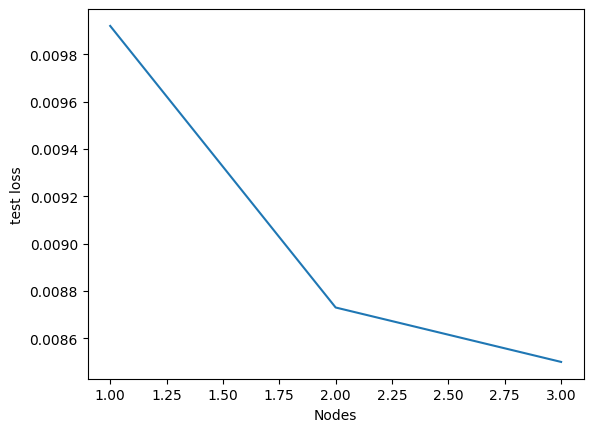

In [42]:
plt.plot([1,2,3],tes_error)
plt.xlabel("Nodes")
plt.ylabel('test loss')
plt.savefig("./graph/test_error.png")
